# Business insights

Translating the EDA findings into concise, actionable insights for planning, exports and subsidy decisions.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set_style('whitegrid')
# load cleaned data
df = pd.read_csv(Path('..') / 'data' / 'processed' / 'cleaned_agriculture_data.csv')
# pivot metrics to wide so production/volume/value become columns if present
wide = df.pivot_table(index=['crop','year'], columns='metric', values='value')
wide = wide.reset_index()
# ensure year is numeric
if 'year' in wide.columns:
    wide['year'] = pd.to_numeric(wide['year'], errors='coerce').astype('Int64')
wide.head()

metric,crop,year,production,value_usd_mn,volume
0,Coconut (mn nuts) (numbers are given und...,2006,NaN,123.900000,456.000000
1,Coconut (mn nuts) (numbers are given und...,2007,NaN,128.500000,457.000000
2,Coconut (mn nuts) (numbers are given und...,2008,NaN,145.133358,380.373020
3,Coconut (mn nuts) (numbers are given und...,2009,NaN,NaN,366.633741
4,Coconut (mn nuts) (numbers are given und...,2010,NaN,NaN,251.143484


## Aggregate growth and volatility

Computing year-over-year production growth and per-crop volatility to separate stable crops from risky ones.

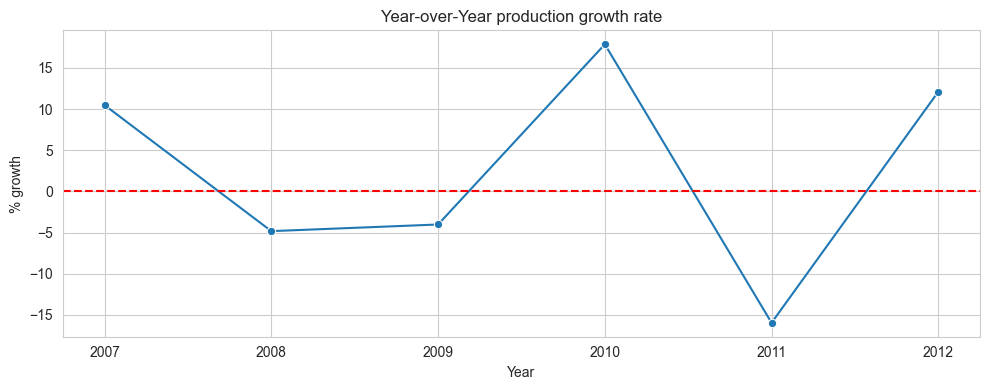

C:\Users\DELL\AppData\Local\Temp\ipykernel_18296\585183065.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_risky.values, y=top_risky.index, palette='Reds_r')


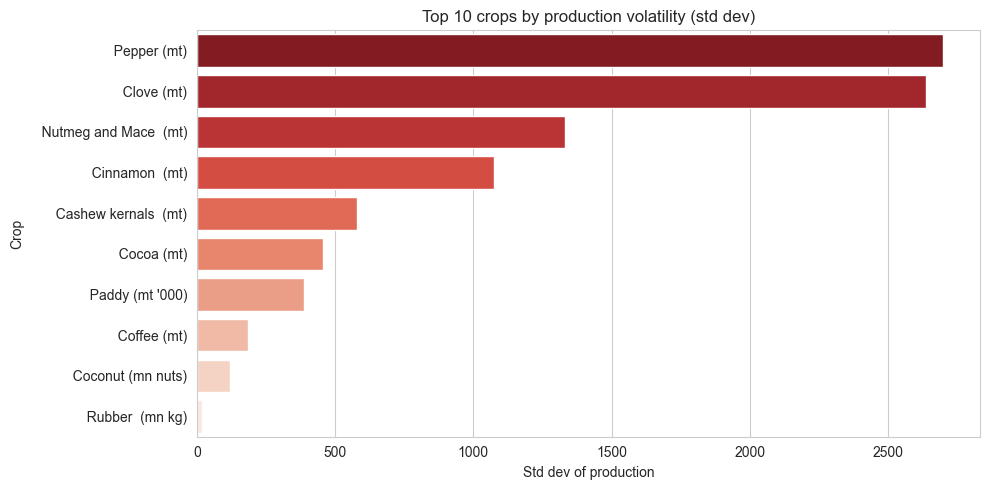

In [2]:
# total production by year (if production column exists)
if 'production' in wide.columns:
    yearly = wide.groupby('year', as_index=False)['production'].sum().dropna()
    yearly['growth_rate'] = yearly['production'].pct_change() * 100
    plt.figure(figsize=(10,4))
    sns.lineplot(data=yearly, x='year', y='growth_rate', marker='o')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Year-over-Year production growth rate')
    plt.xlabel('Year')
    plt.ylabel('% growth')
    plt.tight_layout()
    plt.show()

    # crop volatility (std dev of production across years)
    crop_vol = wide.groupby('crop')['production'].std().dropna().sort_values(ascending=False)
    top_risky = crop_vol.head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_risky.values, y=top_risky.index, palette='Reds_r')
    plt.title('Top 10 crops by production volatility (std dev)')
    plt.xlabel('Std dev of production')
    plt.ylabel('Crop')
    plt.tight_layout()
    plt.show()
else:
    print('No production metric available in data to compute aggregate growth and volatility.')

**Interpreting**

Using volatility to flag risky crops (high std dev) and using aggregate growth to assess whether production is expanding overall.

## Recent production and reliability

Summarizing recent average production per crop (last 3 years in the dataset) to identify which crops consistently contribute most today.

In [3]:
# recent (last 3 years available) average production by crop
if 'production' in wide.columns:
    yrs = wide['year'].dropna().astype(int)
    if len(yrs):
        last = yrs.max()
        recent = wide[wide['year'] >= (last - 2)].groupby('crop')['production'].mean().dropna().sort_values(ascending=False)
        display(recent.head(10))
    else:
        print('No year information available in the data.')
else:
    print('No production metric available to summarize recent production.')

crop
Cinnamon  (mt)           17283.333333
Pepper (mt)              15578.666667
Clove (mt)                6364.333333
Paddy (mt '000)           4013.666667
Coffee (mt)               3046.000000
Coconut (mn nuts)         2777.333333
Nutmeg and Mace  (mt)     2194.666667
Cashew kernals  (mt)      1466.666667
Cocoa (mt)                 519.333333
Tea  (mn kg)               329.100000
Name: production, dtype: float64

In [4]:
# computing simple reliability lists: low volatility & decent recent production
reliable = []
risky = []
if 'production' in wide.columns:
    vol = wide.groupby('crop')['production'].std()
    yrs = wide['year'].dropna().astype(int)
    if len(yrs):
        last = yrs.max()
        mean_recent = wide[wide['year'] >= (last - 2)].groupby('crop')['production'].mean()
    else:
        mean_recent = wide.groupby('crop')['production'].mean()
    vol_med = vol.median() if len(vol) else None
    mean_med = mean_recent.median() if len(mean_recent) else None
    if vol_med is not None and mean_med is not None:
        reliable = mean_recent[(vol.loc[mean_recent.index] <= vol_med) & (mean_recent >= mean_med)].sort_values(ascending=False).index.tolist()
        risky = vol.sort_values(ascending=False).head(10).index.tolist()
    print('Reliable crops (low volatility + strong recent production):', reliable[:10])
    print('Risky crops (high volatility):', risky)
else:
    print('Could not compute reliable/risky lists (missing production metric).')

Reliable crops (low volatility + strong recent production): ["   Paddy (mt '000)", '   Coffee (mt)', '   Coconut (mn nuts)']
Risky crops (high volatility): ['   Pepper (mt)', '   Clove (mt)', '   Nutmeg and Mace  (mt)', '   Cinnamon  (mt)', '   Cashew kernals  (mt)', '   Cocoa (mt)', "   Paddy (mt '000)", '   Coffee (mt)', '   Coconut (mn nuts)', '   Rubber  (mn kg)']


## Conclusions and implications

Translating these data signals into practical recommendations for planning, exports and subsidy targeting.



## Business Insights

Based on the analysis of the data, we can draw the following conclusions:

- **Reliable crops**: Paddy, Coffee, and Coconut are identified as reliable crops based on low volatility and strong recent production. These crops are recommended for prioritization in terms of infrastructure and export support.

- **Risky crops**: Pepper, Clove, Nutmeg & Mace, Cinnamon, Cashew, Cocoa, and Rubber are flagged as high-volatility crops. Targeted investigation and analysis are recommended before committing large budgets for exports or subsidies.

- **Observing growth patterns**: Positive YoY growth is observed in some years (2007, 2010, 2012), while a sharp drop is seen in 2011. Single-year spikes or dips should be treated as short-term events and followed up with crop-level analysis to confirm whether they are structural.

- **Recommending policy and business actions**: Prioritizing reliable crops for logistics, storage, and export pathways. Designing conditional subsidies and insurance for risky crops based on weather or prices. Routing risky crops toward processing or value-added chains when export volatility is high.

- **Additional actions**: Piloting interventions (irrigation, improved seed, post-harvest processing) for risky crops with demonstrated long-term potential.

These insights can guide decision-making and inform strategies for improving crop production, exports, and subsidy allocation in the agricultural sector.